## Behavioral Cloning

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2
import json
from tqdm import tqdm_notebook
from keras.preprocessing import image as kimage
from keras.models import model_from_json
from model import preprocess, calculate_steering, calculate_data_len, generate_data, generate_single, FLAGS
%matplotlib inline

In [2]:
data_dir = 'data_sdc'
driving_log = pd.read_csv(data_dir + '/driving_log.csv', usecols=[0, 1, 2, 3])

In [3]:
driving_log.head()

,center,left,right,steering
0,IMG/center_2016_12_01_13_30_48_287.jpg,IMG/left_2016_12_01_13_30_48_287.jpg,IMG/right_2016_12_01_13_30_48_287.jpg,0.0
1,IMG/center_2016_12_01_13_30_48_404.jpg,IMG/left_2016_12_01_13_30_48_404.jpg,IMG/right_2016_12_01_13_30_48_404.jpg,0.0
2,IMG/center_2016_12_01_13_31_12_937.jpg,IMG/left_2016_12_01_13_31_12_937.jpg,IMG/right_2016_12_01_13_31_12_937.jpg,0.0
3,IMG/center_2016_12_01_13_31_13_037.jpg,IMG/left_2016_12_01_13_31_13_037.jpg,IMG/right_2016_12_01_13_31_13_037.jpg,0.0
4,IMG/center_2016_12_01_13_31_13_177.jpg,IMG/left_2016_12_01_13_31_13_177.jpg,IMG/right_2016_12_01_13_31_13_177.jpg,0.0


In [4]:
driving_log.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
steering,8036.0,0.00407,0.12884,-0.942695,0.0,0.0,0.0,1.0


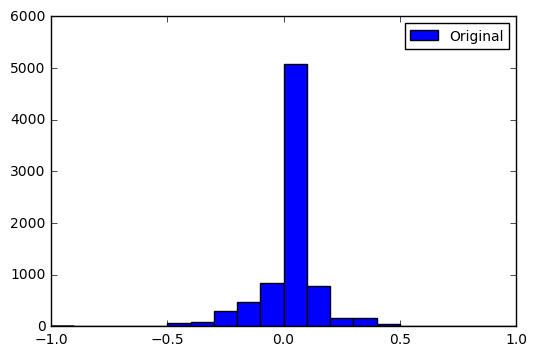

In [5]:
plt.hist(driving_log['steering'], bins=np.arange(-1, 1 + 0.1, 0.1), label="Original");
plt.legend(prop={'size':10}, loc='best')

All steering angles len:  34860


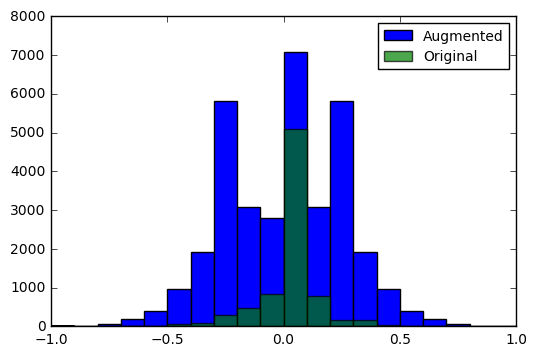

In [34]:
image_labels = ['center', 'right', 'left']
data_len = calculate_data_len(driving_log, positions=len(image_labels))
print("Data len: ", data_len)

all_steering_angles = np.array([])
for images, steering_angles in tqdm_notebook(generate_data(driving_log), total=int(data_len/FLAGS.batch_size)):
    all_steering_angles = np.hstack((all_steering_angles, steering_angles))
    if(len(all_steering_angles)>=data_len):
        break

print("All steering angles len: ", len(all_steering_angles))
plt.hist(all_steering_angles, bins=np.arange(-1, 1 + 0.1, 0.1), label='Augmented');
plt.hist(driving_log['steering'], alpha=0.7, bins=np.arange(-1, 1 + 0.1, 0.1), label='Original');
plt.legend(prop={'size':10}, loc='best')

In [6]:
# Load model
with open("model.json", 'r') as jfile:
    model = model_from_json(jfile.read())
model.compile("adam", "mse")
model.load_weights("model.h5")
print(model.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 18, 80, 3)     0                                            
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 18, 80, 16)    448         input_1[0][0]                    
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 9, 40, 16)     0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 9, 40, 16)     0           maxpooling2d_1[0][0]             
___________________________________________________________________________________________

(1, 18, 80, 16)


/home/vfcosta/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


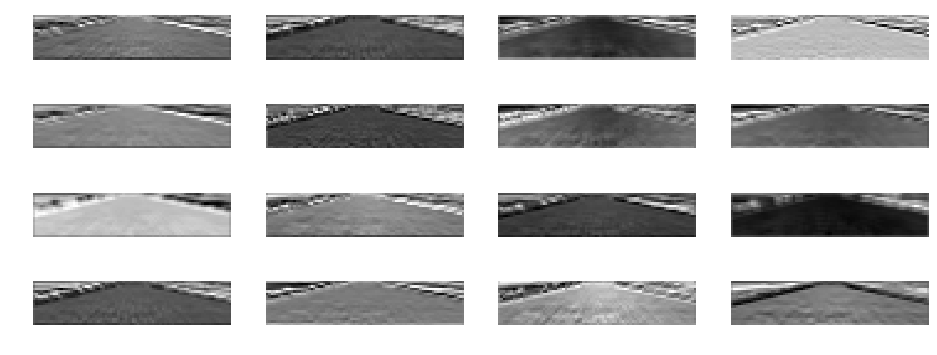

In [7]:
from keras import backend as K
import math

def plot_intermediate(image_array, layer=1, train_mode=1):
    print(model.layers[layer])
    get_layer_output = K.function([model.layers[0].input, K.learning_phase()], [model.layers[layer].output])
    layer_output = get_layer_output([[image_array], train_mode])[0]
    print(layer_output.shape)
    columns = 4
    fig, axs = plt.subplots(int(math.ceil(layer_output.shape[3]/columns)), columns)
    fig.set_size_inches(12, columns*int(27/layer_output.shape[1]))
    fig.subplots_adjust(hspace=1, wspace=0)
    for i in range(0, layer_output.shape[3]):
        ax = axs[i/columns, i%columns]
        ax.axis('off')
        ax.imshow(layer_output[0, :, :, i], cmap='gray', interpolation='nearest');

image = kimage.load_img(data_dir + "/" + driving_log.ix[0]['center'].strip())
plot_intermediate(preprocess(image))

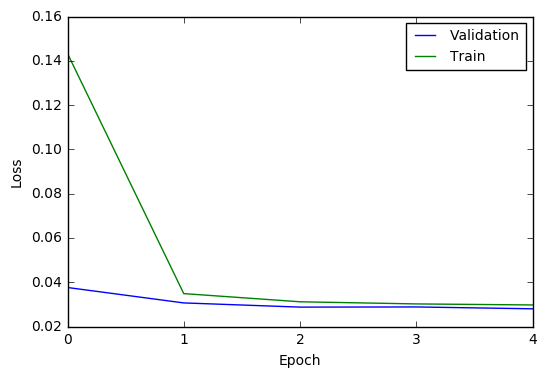

In [8]:
with open("history.json") as infile:
    history = json.load(infile)
    plt.plot(history['val_loss'], label='Validation')
    plt.plot(history['loss'], label='Train')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.xticks(np.arange(0, len(history['loss']), 1.0))
    plt.legend(prop={'size':10}, loc='best')

(18, 80, 3)


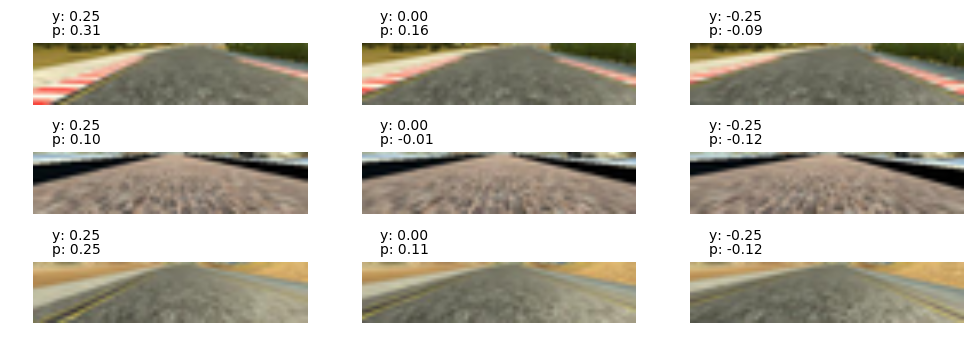

In [9]:
# Plot sample images
n_samples = 3
indexes = np.random.randint(0, len(driving_log), n_samples)
fig, axs = plt.subplots(n_samples, 3)
fig.set_size_inches(12, 4)

for i,index in enumerate(indexes):
    for j,label in enumerate(['left', 'center', 'right']):
        axs[i,j].axis('off')
        steering = driving_log.ix[index]['steering']
        axs[i,j].text(5,-7, "y: %0.2f" % calculate_steering(steering, label))
        image = kimage.load_img(data_dir + "/" + driving_log.ix[index][label].strip())
        image_array = preprocess(image, normalize=False)
        if i==0 and j==0: print(image_array.shape)

        processed_image = preprocess(image)
        predicted_steering = float(model.predict(processed_image[None, :, :, :], batch_size=1))
        axs[i,j].text(5, -3, "p: %0.2f" % predicted_steering)
        axs[i,j].imshow(cv2.cvtColor(image_array, cv2.COLOR_HSV2BGR))

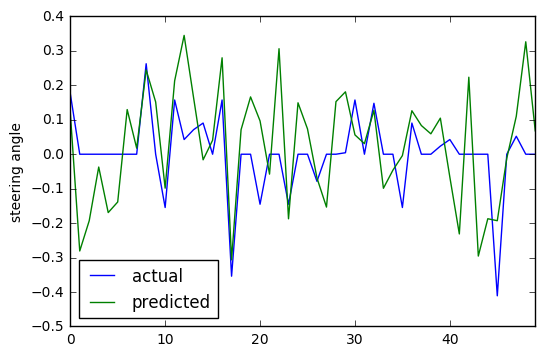

In [34]:
X = []
Y = []
for _, row in driving_log.sample(50).iterrows():
    x, y = generate_single(row)
    X.append(x)
    Y.append(y)

X = np.array(X)
Y = np.array(Y)

P = model.predict(X)
P = P.reshape((P.shape[0],)) 
ax = pd.DataFrame({'predicted':P, 'actual':Y[:500]}).plot()
ax.set_ylabel("steering angle")